# Content

This notebook contains the simulation of the 2D ion crystal with anisotropy parameter $\alpha = 0.248$ (refer to DOI: 10.1038/srep21547). We verify that we obtain the similar structural phase in 2D plane.

The normal modes are calculated with *sion.normal_modes()* function. The normal modes are verified through the calculation of FFT on the normal coordinates of ions from the simulation, using previously obtained modes. If the normal modes are calculated correctly, their frequencies will match with those, calculated by FFT.

In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
                       PointPixelElectrode, PotentialObjective,
                       PatternRangeConstraint, shaped)
import sion as sn




## Trap defiinition

Trap with the requested anisotropy parameter.

Potential minimum: (6.08e-15, 70, 137) mkm
Secular frequencies: (1.226, 2.463, 3.663) MHz
In directions  [[ 1.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -9.99999889e-01  4.70244146e-04]
 [ 0.00000000e+00 -4.70244146e-04 -9.99999889e-01]]
Anisotropy parameter: 0.248


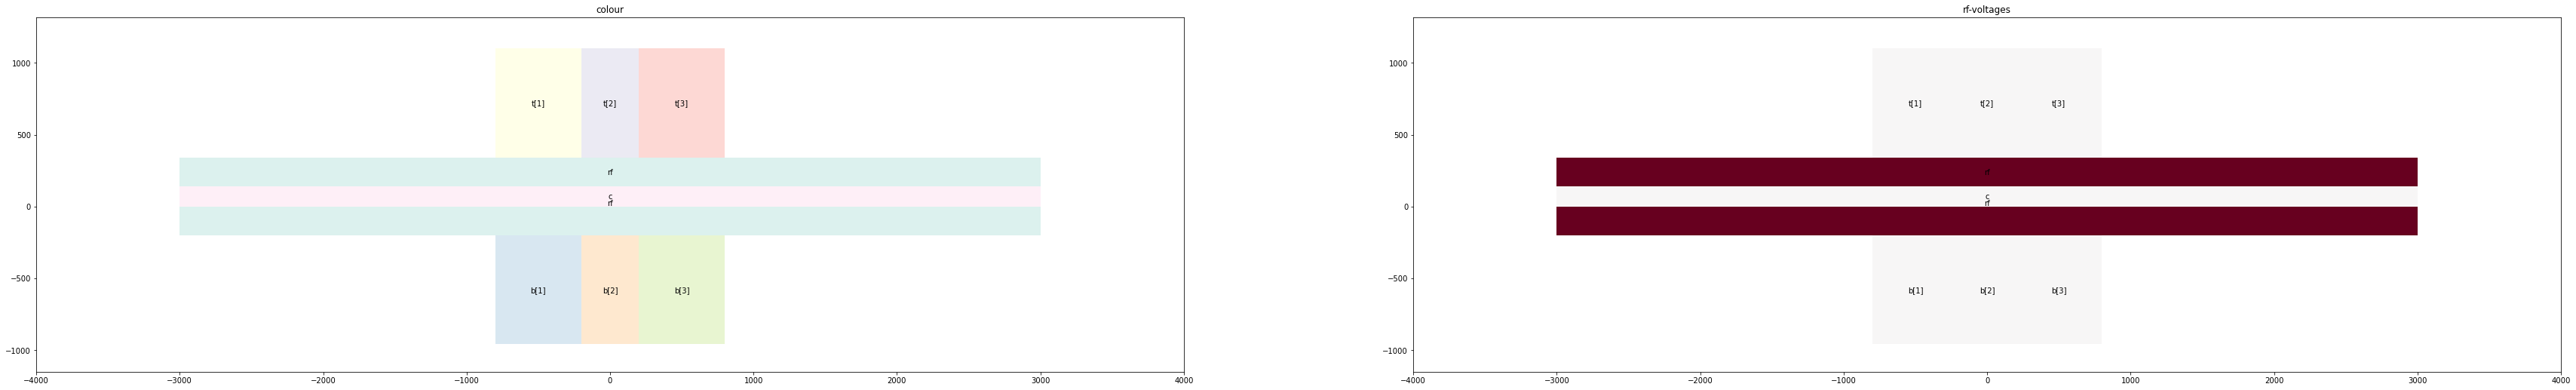

In [2]:
# Global definition of trap parameters.
L = 1e-6 # length scale
Vrf = 199.3 # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion chare
Omega = 2*np.pi*43e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
DCtop = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 140  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 200  # width of top rf electrode, not including width of central electrode
rflength = 6000  # length of rf electrodes
rfbottom = 200  # width of bottom rf electrode
patternTop = 1  # number of groups of Top dc electrodes, defined in DCtop. if None then = 1
patternBot = 1  # same for bottom dcs
getCoordinate = None  # If not None, writes a file with coordinates of vertexes of electrodes
gapped = 0  # gaps between central DC electrode and RF lines
cheight = 1000  # height of the grounded cover electrode plane
cmax = 0  # order of the expansion of cover potential. if 0 - coder not considered, if 5 - considered with optimal precision
plot = 1

elec, Numb, sist = sn.FiveWireTrap(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, patternTop, patternBot, getCoordinate, gapped, cheight, cmax, plot)

x0 = L*np.array(sist.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
u_set = np.array([0, 15, -15, 15, 15, -15, 15, 1.40251])
# routine to find secular frequencies in minimum point
with sist.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x = sist.minimum((0., 90, 120), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('Potential minimum: (%.3g, %.3g, %.3g) mkm' % (x[0], x[1], x[2]))

    # Get trap frequencies
    try:
        curv_z, mod_dir = sist.modes(x, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        print("In directions ", mod_dir)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6

## Equilibrium ion positions

The simulation of 10 ions is performed in the presence of cooling, to obtain their equilibrium positions.

Reducing timestep to 1.8506388731615735e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  10 settings made for charge
10 atoms in group 1
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  

C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Final positions of ions in mkm:
 [[ -9.35  70.   137.01]
 [ -5.57  72.08 137.05]
 [ -5.57  67.92 137.05]
 [ -1.8   67.88 137.06]
 [ -1.8   72.12 137.06]
 [  1.8   67.88 137.06]
 [  1.8   72.12 137.06]
 [  5.57  67.92 137.05]
 [  5.57  72.08 137.05]
 [  9.35  70.   137.01]]


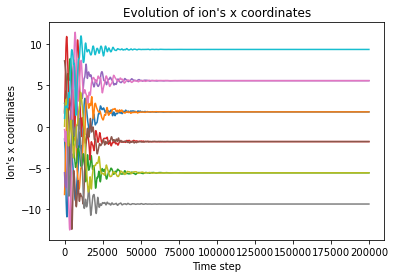

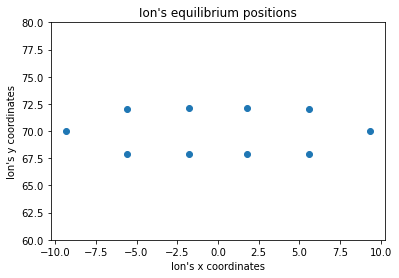

In [3]:

ion_number = 10
x0 = x*1e-6

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x0, ion_number, 10e-6)
s.append(pl.placeions(ions, positions))

#declaration of a five wire trap
s.append(sn.five_wire_trap(Omega, Vrf, u_set, elec, Numb, [cmax, cheight]))

#temperature initialization
s.append(pl.thermalvelocities(5, False))

#cooling simulation
s.append(pl.langevinbath(0, 1e-6))

#files with simulation information
s.append(pl.dump('2Dpositions_eq.txt', variables=['x', 'y', 'z'], steps=10))
s.append(pl.evolve(2e5))
s.execute()

_, data = pl.readdump('2Dpositions_eq.txt')
data *= 1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] =  np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

np.set_printoptions(2)
print('Final positions of ions in mkm:\n', ion_positions)


plt.figure()
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([60, 80])
plt.show()


## Resulting crystal

The resulting crystal form (demonstrated above), is matching the one from the reference article. 

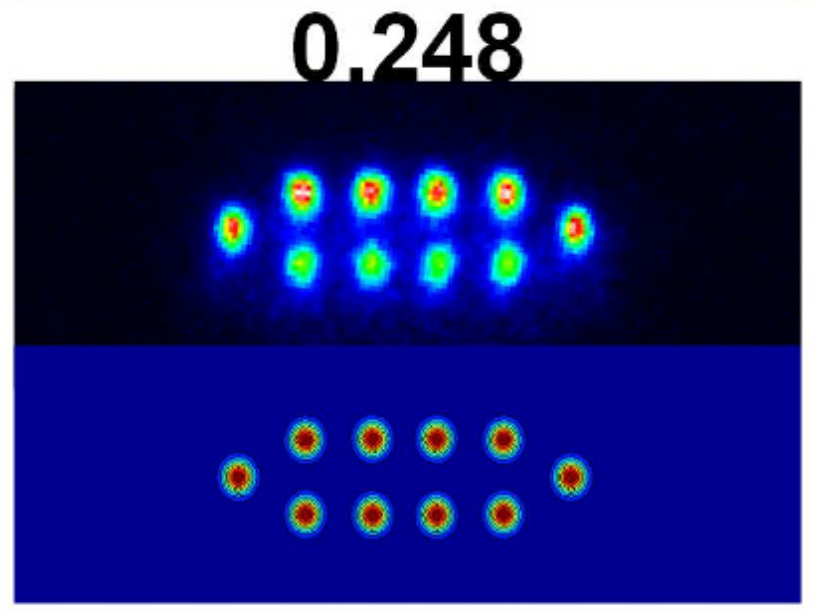

## Ion crystal normal modes

For this 2D crystal we calculate normal mode vectors and their frequencies. The normal mode spectrum is consensual with qualitative analysis. Z-axis modes are mostly uncoupled to the rest modes, because the crystal has almost 0 distribution along z-axis. Additionally, edge ions are less coupled to the main bulk of central 8 ions. 

Normal mode frequencies: [ 638253.97523357  937638.96338324 1226192.83255368 1387780.79300443
 1626044.33406041 1860093.88676707 1886032.32432904 2029951.93821143
 2053700.13369267 2268080.58182547 2273136.69626949 2364367.36769613
 2388166.62973246 2462682.30786135 2464168.00723657 2532361.94643211
 2716649.50924011 2759647.52438515 2921031.39381269 2926435.9473752
 3001772.51427905 3043823.86882278 3221772.099667   3259547.24595829
 3319460.49297846 3440237.47284001 3459545.84206346 3528396.48317495
 3663317.66770751 3866271.5653881 ]


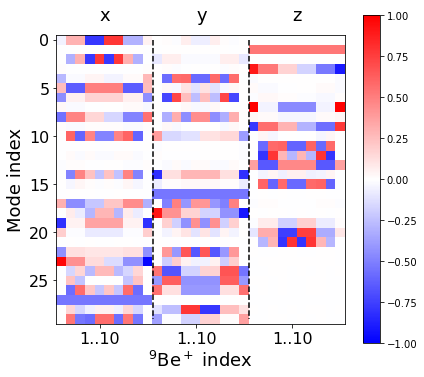

In [3]:
ion_number = 10
ion_masses = [mass for el in range(ion_number)]
omegas = [omega_sec for el in range(ion_number)]
ion_positions = np.array([[ -9.35,  70. ,  137.01],
 [ -5.57,  67.92, 137.05],
 [ -5.57,  72.08, 137.05],
 [ -1.8 ,  72.12, 137.06],
 [ -1.8 ,  67.88, 137.06],
 [  1.8 ,  67.88, 137.06],
 [  1.8 ,  72.12, 137.06],
 [  5.57,  67.92, 137.05],
 [  5.57,  72.08, 137.05],
 [  9.35,  70.  , 137.01]])*L

#obtaining normal modes, for general case
freqs, modes = sn.normal_modes(ion_positions, omegas, ion_masses)
print("Normal mode frequencies:", freqs)

plt.figure(figsize = [6, 6])
plt.imshow(modes[::-1,:] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
plt.colorbar(shrink = 0.8)
plt.tight_layout()
plt.vlines([9.5,19.5], ymin = 0, ymax = 29 ,linestyles = 'dashed', color = 'k')
plt.locator_params(axis='x', nbins=3)
plt.text(4, -2,'x', fontsize = 18)
plt.text(14,-2,'y',fontsize = 18)
plt.text(24, -2,'z',fontsize = 18)
plt.xlabel('$^{9}$Be$^+$ index', fontsize = 18)
plt.ylabel('Mode index', fontsize = 18)
plt.xticks([4, 14, 24],['1..10', '1..10', '1..10'],fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.show()

# Crystal frequencies from Fourier analysis

## Simulation without cooling

This file performs simulation of ions near their equilibrium positions, oscillating from random initial displacement.

In [4]:
ion_positions = np.array([[ -9.35,  70. ,  137.01],
 [ -5.57,  67.92, 137.05],
 [ -5.57,  72.08, 137.05],
 [ -1.8 ,  72.12, 137.06],
 [ -1.8 ,  67.88, 137.06],
 [  1.8 ,  67.88, 137.06],
 [  1.8 ,  72.12, 137.06],
 [  5.57,  67.92, 137.05],
 [  5.57,  72.08, 137.05],
 [  9.35,  70.  , 137.01]])

_, data = pl.readdump('2Dpositions_eq.txt')
data *= 1e6
final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]
ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)
k=0
for i in sort:
    ion_positions[k] =  np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

start_positions = []
for pos in ion_positions:
    start_positions.append(L*(pos + 0.0001*(np.random.rand(3)-np.array([0.5,0.5,0.5]))))

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
s.append(pl.placeions(ions, start_positions))

#declaration of a five wire trap
s.append(sn.five_wire_trap(Omega, Vrf, u_set, elec, Numb, [cmax, cheight]))

#files with simulation information
s.append(pl.dump('2Dpositions.txt', variables=['x', 'y', 'z'], steps=1))
s.append(pl.evolve(3e6))
s.execute()

_, data = pl.readdump('2Dpositions.txt')
data *= 1e6


Reducing timestep to 1.8506388731615735e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  10 settings made for charge
10 atoms in group 1
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  

C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


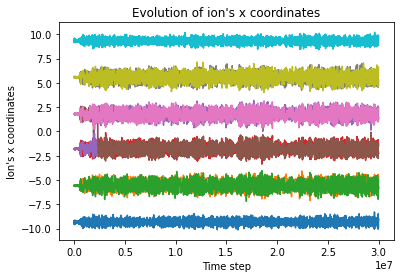

In [5]:
plt.figure()
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

## Calculation of FFT frequencies

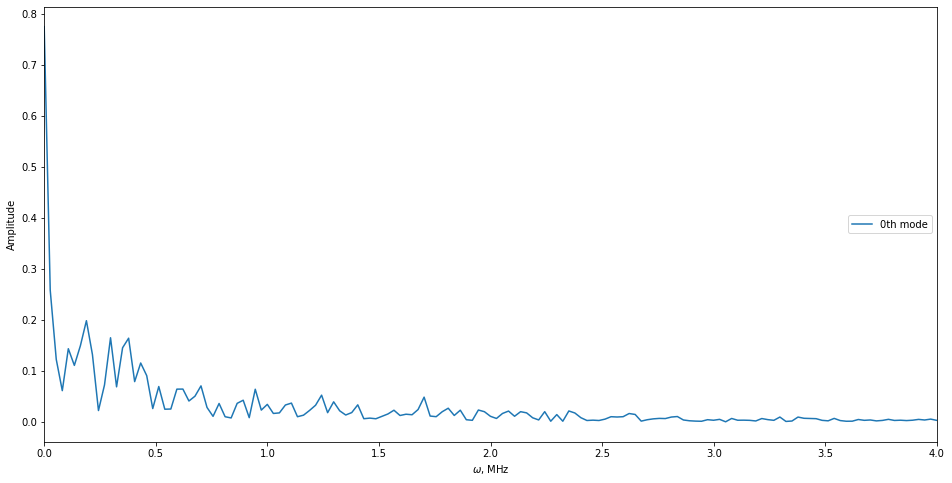

In [20]:
_, data = pl.readdump('2Dpositions.txt')
x = data[:, 3, 0]
y = data[:, :, 1]
z = data[:, :, 2]

T = data.shape[0]/(20*Omega) # simulation time
freqsfft = np.arange(data.shape[0])/T/1e6

ion_spectrum = np.abs(np.fft.fft(x))

plt.figure(figsize = (16,8))
plt.plot(freqsfft[:data.shape[0]//2], ion_spectrum[:data.shape[0]//2], label = str(0)+'th mode')
plt.legend(loc = 'right')
plt.xlabel('$\omega$, MHz')
plt.xlim(0, 4)
plt.ylabel('Amplitude')
plt.show()

0.0005551918470123595
5403.537562995257


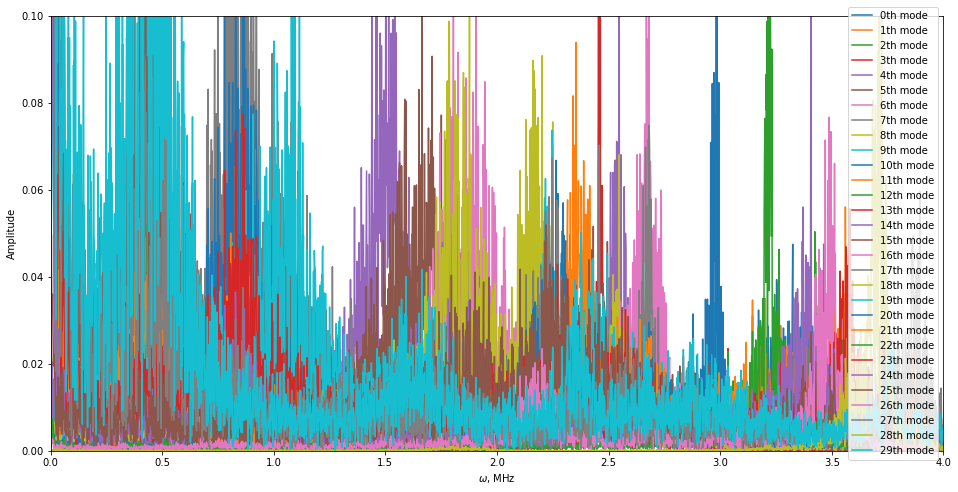

In [6]:
_, data = pl.readdump('2Dpositions.txt')
x = data[:, :, 0]
y = data[:, :, 1]
z = data[:, :, 2]

T = data.shape[0]/(20*Omega) # simulation time
print(T)
freqsfft = np.arange(data.shape[0])/T/1e6
print(freqsfft[-1])

normal_coordinates = []
rev_modes = -modes
for mode in rev_modes:
    coord = np.zeros(data.shape[0])
    for i in range(ion_number):
        for j in range(3):
            coord = coord + mode[i + ion_number*j]*(data[:, i, j])
    normal_coordinates.append(coord)
normal_spectrum = []
for norm_coord in normal_coordinates:
    ion_spectrum = np.fft.fft(norm_coord)
    normal_spectrum.append(np.abs(ion_spectrum))
    
plt.figure(figsize = (16,8))
for n, ion_spectrum in enumerate(normal_spectrum):
    plt.plot(freqsfft, ion_spectrum, label = str(n)+'th mode')
plt.legend(loc = 'right')
plt.xlabel('$\omega$, MHz')
plt.xlim(0, 4)
plt.ylim(0, 0.1)
plt.ylabel('Amplitude')
plt.show()

0.6382539752335722
[ 1.03871453e-15  3.18077568e-01 -3.18077568e-01 -3.37643364e-01
  3.37643364e-01  3.37643364e-01 -3.37643364e-01  3.18077568e-01
 -3.18077568e-01  1.13873050e-15 -2.17932990e-01 -5.07537600e-03
 -5.07537600e-03 -1.05116763e-01 -1.05116763e-01  1.05116763e-01
  1.05116763e-01  5.07537600e-03  5.07537600e-03  2.17932990e-01
 -2.68882139e-17 -9.26286001e-04  9.26286001e-04  2.71221978e-04
 -2.71221978e-04  2.71221978e-04 -2.71221978e-04  9.26286001e-04
 -9.26286001e-04  3.23092247e-17]


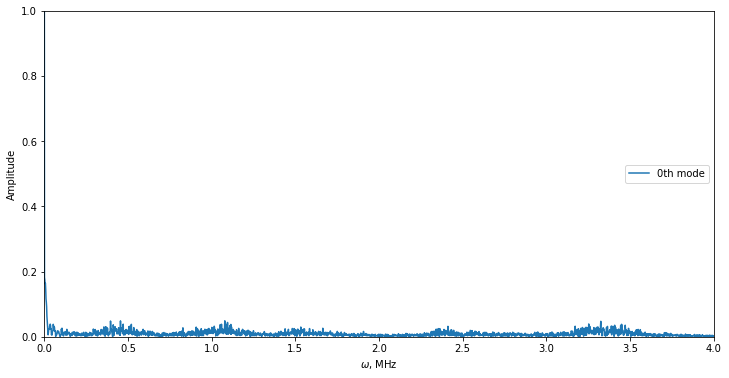

0.9376389633832409
[ 5.03125092e-16  9.41671171e-02 -9.41671171e-02 -3.23802467e-02
  3.23802467e-02  3.23802467e-02 -3.23802467e-02  9.41671171e-02
 -9.41671171e-02  5.59792826e-16 -6.50368772e-02 -1.51519187e-01
 -1.51519187e-01  4.63691473e-01  4.63691473e-01 -4.63691473e-01
 -4.63691473e-01  1.51519187e-01  1.51519187e-01  6.50368772e-02
  3.49113100e-17 -7.57946418e-04  7.57946418e-04 -8.68884611e-04
  8.68884611e-04 -8.68884611e-04  8.68884611e-04  7.57946418e-04
 -7.57946418e-04  7.13540555e-17]


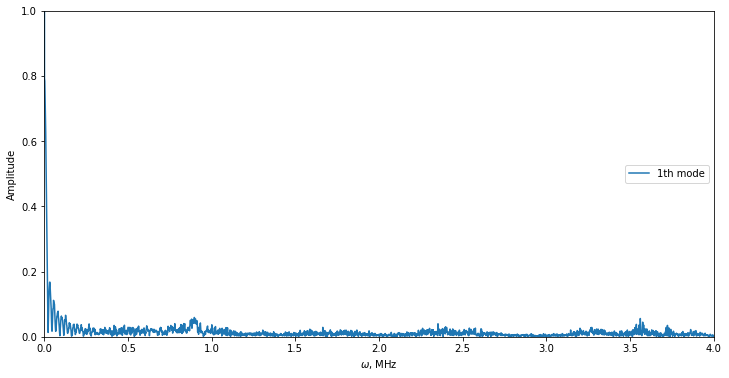

1.226192832553678
[-3.16227766e-01 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01
 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01
 -3.16227766e-01 -3.16227766e-01  7.66632532e-16 -2.45518498e-16
 -2.71996815e-16 -3.75134797e-16 -4.07838779e-16 -2.62705971e-16
 -7.30506452e-16 -1.01915004e-16  1.55474592e-16  1.45369127e-15
  3.46944695e-18 -3.46944695e-18 -1.21430643e-17  1.52872506e-17
  1.39862080e-17 -1.56125113e-17 -5.52943108e-18  6.79659237e-18
 -9.47999275e-18  8.13151629e-19]


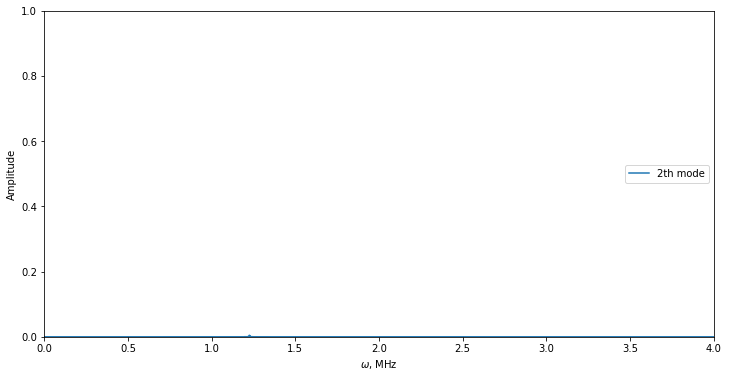

1.3877807930044261
[-2.81489013e-16 -3.40691310e-01  3.40691310e-01  1.30824777e-01
 -1.30824777e-01  1.30824777e-01 -1.30824777e-01  3.40691310e-01
 -3.40691310e-01  2.17907113e-15  3.32719132e-01  7.11268538e-02
  7.11268538e-02 -2.37486420e-01 -2.37486420e-01 -2.37486420e-01
 -2.37486420e-01  7.11268538e-02  7.11268538e-02  3.32719132e-01
 -6.24500451e-17  1.85206353e-03 -1.85206353e-03  1.01925950e-03
 -1.01925950e-03 -1.01925950e-03  1.01925950e-03  1.85206353e-03
 -1.85206353e-03  1.02999206e-18]


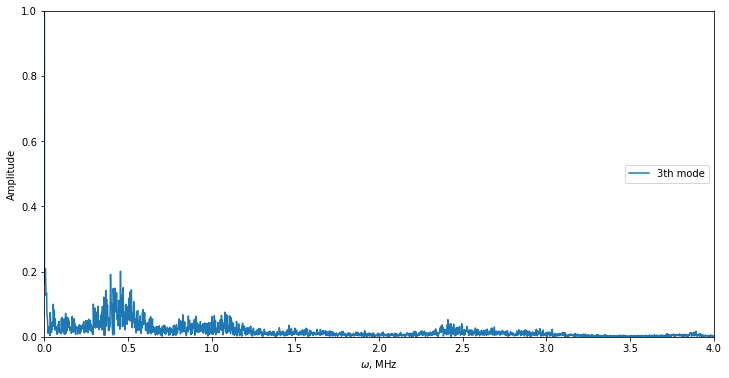

1.6260443340604067
[-8.85808761e-16  1.38404634e-01 -1.38404634e-01 -2.66410632e-03
  2.66410632e-03 -2.66410632e-03  2.66410632e-03 -1.38404634e-01
  1.38404634e-01  5.44207023e-16 -2.36145551e-01  3.72073072e-01
  3.72073072e-01 -2.54000297e-01 -2.54000297e-01 -2.54000297e-01
 -2.54000297e-01  3.72073072e-01  3.72073072e-01 -2.36145551e-01
  1.11455983e-16  4.12680645e-04 -4.12680645e-04  8.47460273e-05
 -8.47460273e-05 -8.47460273e-05  8.47460273e-05  4.12680645e-04
 -4.12680645e-04  2.68204512e-17]


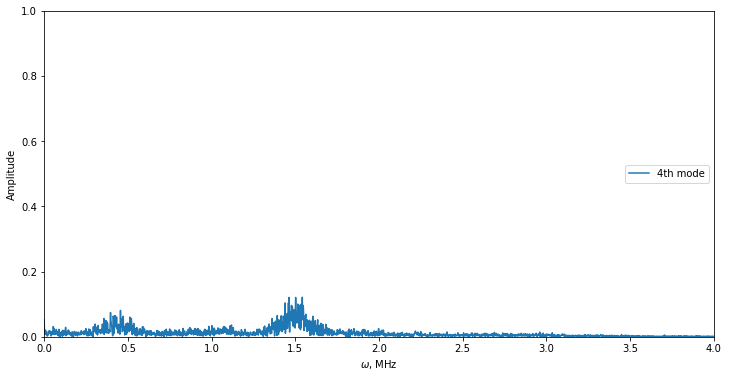

1.8600938867670687
[-4.26256693e-15 -9.62986822e-02  9.62986822e-02 -1.58039209e-01
  1.58039209e-01  1.58039209e-01 -1.58039209e-01 -9.62986822e-02
  9.62986822e-02  6.90481731e-15  3.20982844e-01 -3.93346558e-01
 -3.93346558e-01 -9.74971410e-02 -9.74971410e-02  9.74971410e-02
  9.74971410e-02  3.93346558e-01  3.93346558e-01 -3.20982844e-01
 -7.04731412e-17 -2.23540260e-04  2.23540260e-04  2.81465559e-03
 -2.81465559e-03  2.81465559e-03 -2.81465559e-03  2.23540260e-04
 -2.23540260e-04  1.61349612e-16]


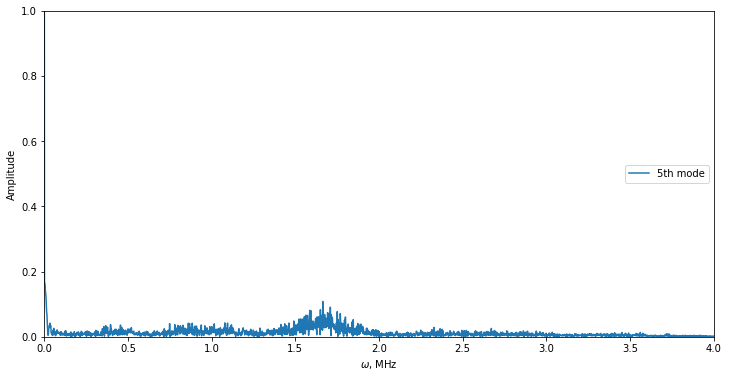

1.8860323243290438
[ 5.75971194e-01  2.54471292e-01  2.54471292e-01  7.88209828e-02
  7.88209828e-02 -7.88209828e-02 -7.88209828e-02 -2.54471292e-01
 -2.54471292e-01 -5.75971194e-01  3.88018954e-15 -1.11110404e-01
  1.11110404e-01  2.84429953e-02 -2.84429953e-02 -2.84429953e-02
  2.84429953e-02 -1.11110404e-01  1.11110404e-01 -2.48347084e-15
 -2.95876525e-03  1.06273361e-03  1.06273361e-03  4.16649015e-04
  4.16649015e-04  4.16649015e-04  4.16649015e-04  1.06273361e-03
  1.06273361e-03 -2.95876525e-03]


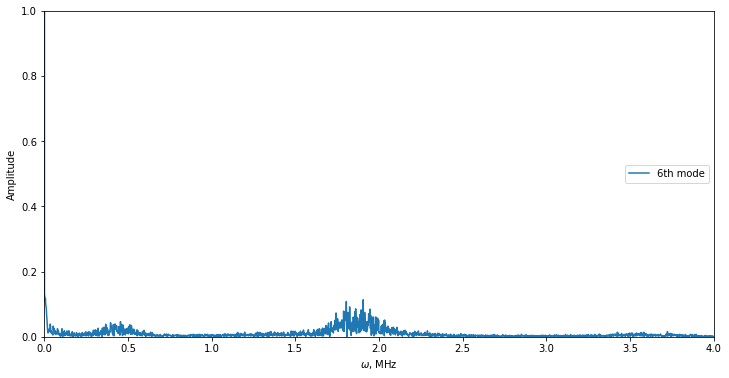

2.0299519382114313
[-2.54978567e-01  7.09991099e-02  7.09991099e-02  5.64901736e-02
  5.64901736e-02  5.64901736e-02  5.64901736e-02  7.09991099e-02
  7.09991099e-02 -2.54978567e-01  4.98990342e-16  2.37456839e-01
 -2.37456839e-01  3.90984335e-01 -3.90984335e-01  3.90984335e-01
 -3.90984335e-01 -2.37456839e-01  2.37456839e-01 -5.68180948e-16
  2.61944716e-03 -1.64244078e-03 -1.64244078e-03  5.68030774e-04
  5.68030774e-04 -5.68030774e-04 -5.68030774e-04  1.64244078e-03
  1.64244078e-03 -2.61944716e-03]


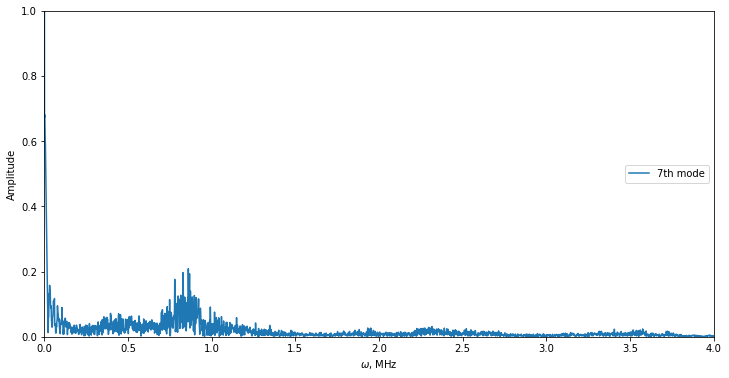

2.0537001336926672
[-2.15283273e-16  1.77331921e-03 -1.77331921e-03  1.61528152e-03
 -1.61528152e-03 -1.61528152e-03  1.61528152e-03  1.77331921e-03
 -1.77331921e-03 -2.31762751e-16  2.60819485e-03 -2.76572620e-03
 -2.76572620e-03 -2.12537348e-03 -2.12537348e-03  2.12537348e-03
  2.12537348e-03  2.76572620e-03  2.76572620e-03 -2.60819485e-03
  6.94600898e-17 -1.68192592e-01  1.68192592e-01 -4.70839602e-01
  4.70839602e-01 -4.70839602e-01  4.70839602e-01  1.68192592e-01
 -1.68192592e-01 -1.99299017e-16]


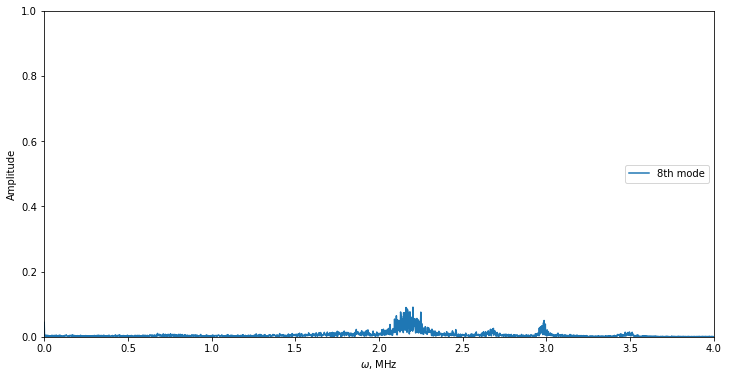

2.2680805818254655
[ 1.13866084e-01 -9.19874678e-03 -9.19874678e-03 -4.77342952e-02
 -4.77342952e-02 -4.77342952e-02 -4.77342952e-02 -9.19874678e-03
 -9.19874678e-03  1.13866084e-01  1.93972967e-16 -2.39298771e-02
  2.39298771e-02  6.18690933e-02 -6.18690933e-02  6.18690933e-02
 -6.18690933e-02  2.39298771e-02 -2.39298771e-02  3.60401683e-16
 -5.58613705e-02  1.91804608e-01  1.91804608e-01 -4.45426088e-01
 -4.45426088e-01  4.45426088e-01  4.45426088e-01 -1.91804608e-01
 -1.91804608e-01  5.58613705e-02]


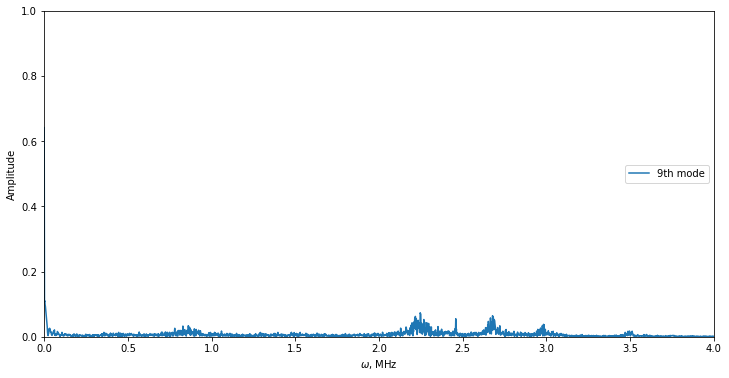

2.273136696269495
[-4.78278099e-01  2.80841528e-02  2.80841528e-02  2.11054897e-01
  2.11054897e-01  2.11054897e-01  2.11054897e-01  2.80841528e-02
  2.80841528e-02 -4.78278099e-01 -2.95090463e-15  1.06906129e-01
 -1.06906129e-01 -2.56119733e-01  2.56119733e-01 -2.56119733e-01
  2.56119733e-01 -1.06906129e-01  1.06906129e-01  2.63568099e-15
 -6.34851823e-03  4.23061546e-02  4.23061546e-02 -1.07032427e-01
 -1.07032427e-01  1.07032427e-01  1.07032427e-01 -4.23061546e-02
 -4.23061546e-02  6.34851823e-03]


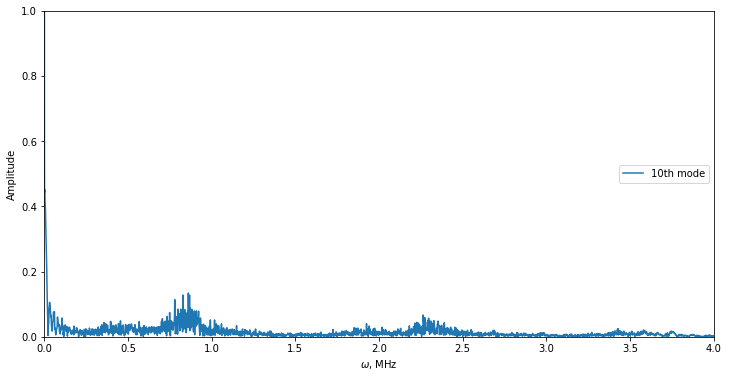

2.364367367696126
[-2.80287329e-15  4.41306106e-02 -4.41306106e-02 -1.67773817e-01
  1.67773817e-01  1.67773817e-01 -1.67773817e-01  4.41306106e-02
 -4.41306106e-02 -2.25797732e-15  5.40720093e-01  2.52504450e-01
  2.52504450e-01  9.97484558e-02  9.97484558e-02 -9.97484558e-02
 -9.97484558e-02 -2.52504450e-01 -2.52504450e-01 -5.40720093e-01
  1.49077799e-16 -2.65774870e-03  2.65774870e-03  1.04197141e-04
 -1.04197141e-04  1.04197141e-04 -1.04197141e-04  2.65774870e-03
 -2.65774870e-03  1.26482348e-16]


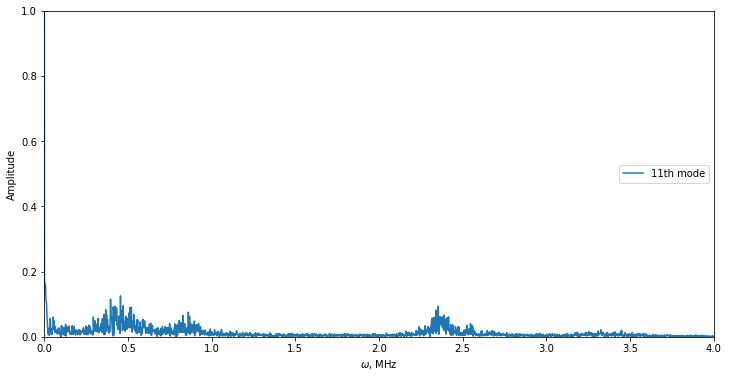

2.3881666297324613
[ 1.83145606e-01 -2.67584816e-01 -2.67584816e-01 -1.30561794e-01
 -1.30561794e-01  1.30561794e-01  1.30561794e-01  2.67584816e-01
  2.67584816e-01 -1.83145606e-01  5.45101976e-15 -2.92728145e-01
  2.92728145e-01 -2.42547129e-01  2.42547129e-01  2.42547129e-01
 -2.42547129e-01 -2.92728145e-01  2.92728145e-01  3.81778902e-15
 -6.01618102e-03  5.93855413e-03  5.93855413e-03 -2.93046362e-03
 -2.93046362e-03 -2.93046362e-03 -2.93046362e-03  5.93855413e-03
  5.93855413e-03 -6.01618102e-03]


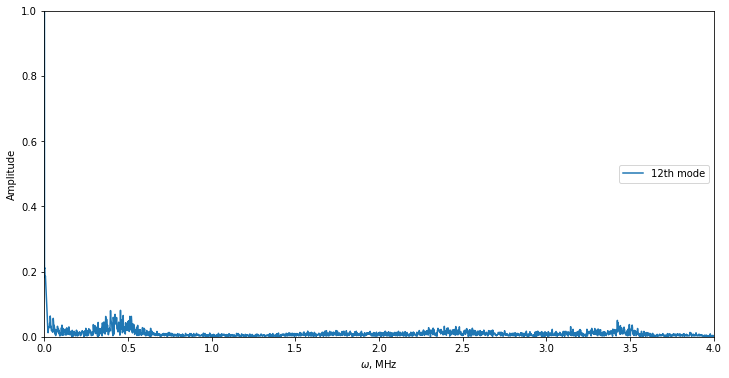

2.4626823078613542
[ 2.73202862e-17  6.90609016e-17  4.48777273e-16  5.26276456e-16
 -3.73146676e-16 -5.71615426e-16  3.94276534e-16 -2.14764654e-16
 -2.62265692e-16 -6.38077133e-17 -3.16227766e-01 -3.16227766e-01
 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01
 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01 -3.16227766e-01
 -5.06965754e-17  1.96747253e-14 -1.96250277e-14  1.95703816e-14
 -1.89422379e-14 -1.95941835e-14  1.87543486e-14  2.08036389e-14
 -2.02746130e-14 -7.01193985e-17]


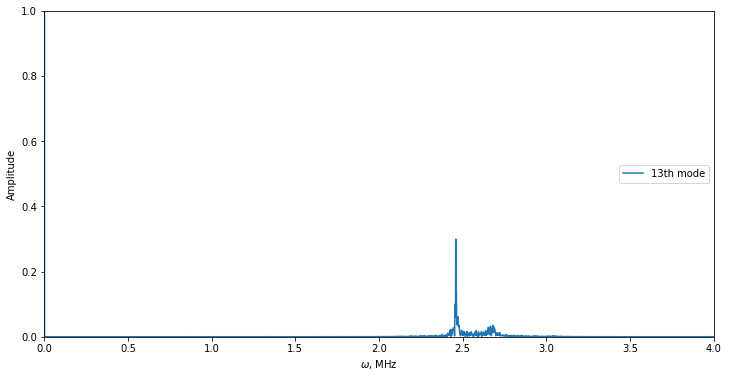

2.4641680072365744
[ 3.00112997e-16 -2.26321569e-02  2.26321569e-02  8.43485438e-03
 -8.43485438e-03  8.43485438e-03 -8.43485438e-03  2.26321569e-02
 -2.26321569e-02 -2.64467384e-16 -4.02535751e-02  5.32943232e-03
  5.32943232e-03  1.47973552e-02  1.47973552e-02  1.47973552e-02
  1.47973552e-02  5.32943232e-03  5.32943232e-03 -4.02535751e-02
 -4.91739895e-16  3.59506731e-01 -3.59506731e-01  3.45128975e-01
 -3.45128975e-01 -3.45128975e-01  3.45128975e-01  3.59506731e-01
 -3.59506731e-01 -5.45182592e-16]


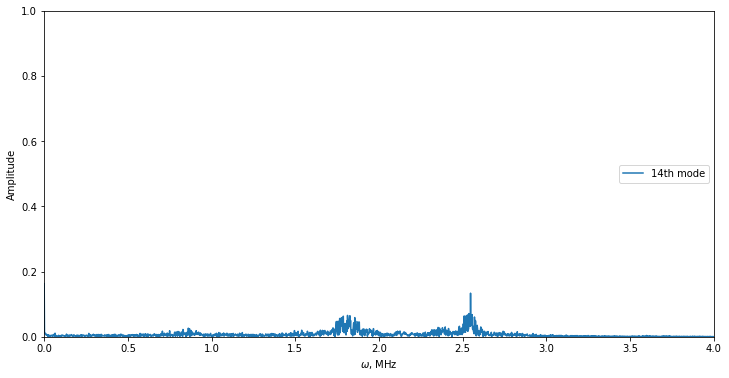

2.5323619464321063
[ 2.20171168e-15 -2.83308864e-01  2.83308864e-01  1.40938344e-01
 -1.40938344e-01  1.40938344e-01 -1.40938344e-01  2.83308864e-01
 -2.83308864e-01 -1.61785014e-15 -4.78799730e-01  7.00783100e-02
  7.00783100e-02  1.69321555e-01  1.69321555e-01  1.69321555e-01
  1.69321555e-01  7.00783100e-02  7.00783100e-02 -4.78799730e-01
 -2.46330734e-16 -2.48638300e-02  2.48638300e-02 -3.23869072e-02
  3.23869072e-02  3.23869072e-02 -3.23869072e-02 -2.48638300e-02
  2.48638300e-02 -2.72405796e-16]


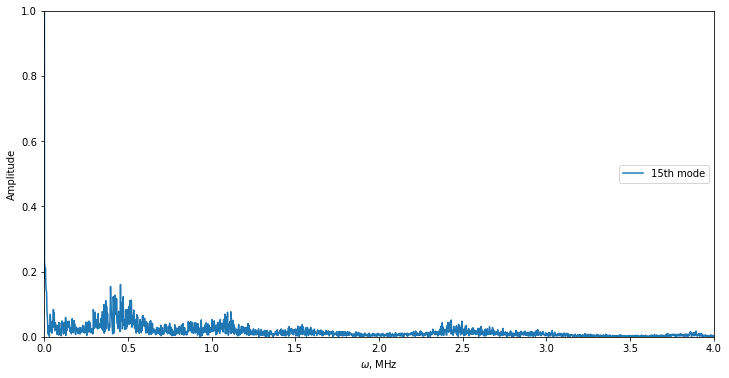

2.716649509240105
[-6.24150839e-03  5.93030951e-03  5.93030951e-03 -1.14092958e-03
 -1.14092958e-03  1.14092958e-03  1.14092958e-03 -5.93030951e-03
 -5.93030951e-03  6.24150839e-03 -8.52123906e-16 -1.15436923e-02
  1.15436923e-02 -9.88662321e-03  9.88662321e-03  9.88662321e-03
 -9.88662321e-03 -1.15436923e-02  1.15436923e-02 -5.40479277e-16
  2.21322908e-01 -3.86312717e-01 -3.86312717e-01  2.75651263e-01
  2.75651263e-01  2.75651263e-01  2.75651263e-01 -3.86312717e-01
 -3.86312717e-01  2.21322908e-01]


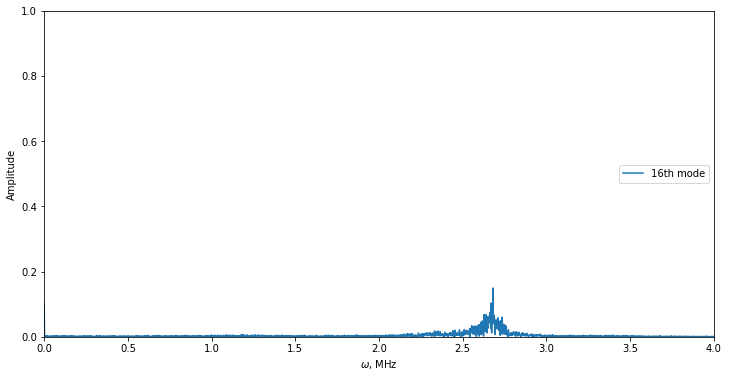

2.7596475243851453
[-0.00000000e+00  1.38273909e-02 -1.38273909e-02  1.34696453e-02
 -1.34696453e-02 -1.34696453e-02  1.34696453e-02  1.38273909e-02
 -1.38273909e-02 -2.76837413e-17  6.29331737e-03 -3.97082138e-03
 -3.97082138e-03 -3.17743753e-03 -3.17743753e-03  3.17743753e-03
  3.17743753e-03  3.97082138e-03  3.97082138e-03 -6.29331737e-03
  6.39435336e-16 -4.70416989e-01  4.70416989e-01  1.68195013e-01
 -1.68195013e-01  1.68195013e-01 -1.68195013e-01  4.70416989e-01
 -4.70416989e-01 -3.37486048e-15]


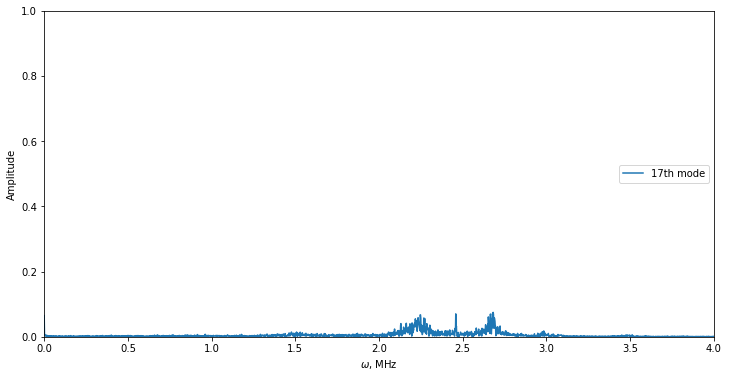

2.9210313938126875
[-2.93482511e-17 -3.52846434e-03  3.52846434e-03  2.53516880e-03
 -2.53516880e-03  2.53516880e-03 -2.53516880e-03  3.52846434e-03
 -3.52846434e-03  4.39310511e-17 -5.55265145e-03  1.04968020e-03
  1.04968020e-03  1.72664553e-03  1.72664553e-03  1.72664553e-03
  1.72664553e-03  1.04968020e-03  1.04968020e-03 -5.55265145e-03
  1.30619257e-16 -3.46593884e-01  3.46593884e-01  3.60325275e-01
 -3.60325275e-01 -3.60325275e-01  3.60325275e-01 -3.46593884e-01
  3.46593884e-01  8.50662907e-16]


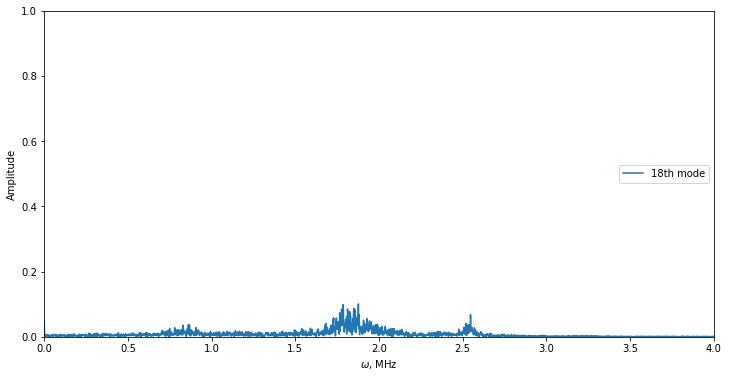

2.9264359473752024
[-1.22323198e-15  3.58530230e-01 -3.58530230e-01  2.85727130e-01
 -2.85727130e-01 -2.85727130e-01  2.85727130e-01  3.58530230e-01
 -3.58530230e-01  4.51679919e-16  2.29827768e-01 -9.22645539e-02
 -9.22645539e-02 -6.68627205e-02 -6.68627205e-02  6.68627205e-02
  6.68627205e-02  9.22645539e-02  9.22645539e-02 -2.29827768e-01
 -4.37150316e-16  2.02623489e-02 -2.02623489e-02 -3.42718439e-03
  3.42718439e-03 -3.42718439e-03  3.42718439e-03 -2.02623489e-02
  2.02623489e-02  1.68485018e-16]


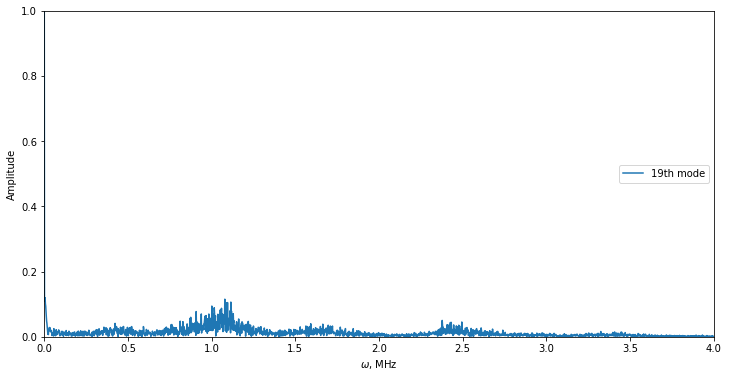

3.00177251427905
[ 5.19912426e-03 -1.03733339e-02 -1.03733339e-02  7.77377176e-03
  7.77377176e-03  7.77377176e-03  7.77377176e-03 -1.03733339e-02
 -1.03733339e-02  5.19912426e-03 -1.59168298e-16  1.51638723e-02
 -1.51638723e-02 -4.04467775e-03  4.04467775e-03 -4.04467775e-03
  4.04467775e-03 -1.51638723e-02  1.51638723e-02  5.73794401e-17
 -4.61255726e-01  3.36752838e-01  3.36752838e-01  1.72601414e-01
  1.72601414e-01 -1.72601414e-01 -1.72601414e-01 -3.36752838e-01
 -3.36752838e-01  4.61255726e-01]


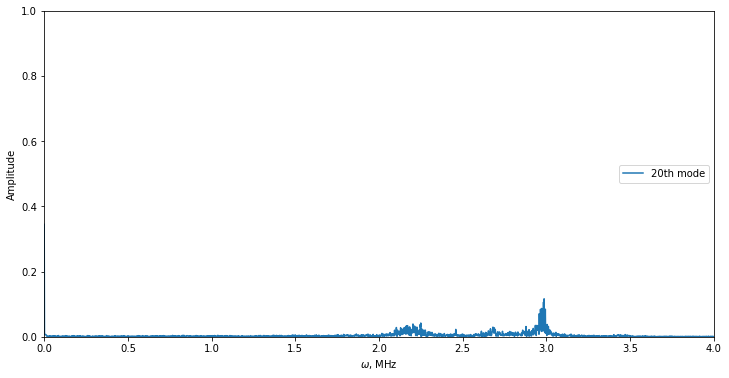

3.0438238688227806
[-3.26360052e-01  2.86706789e-01  2.86706789e-01  9.56089123e-02
  9.56089123e-02 -9.56089123e-02 -9.56089123e-02 -2.86706789e-01
 -2.86706789e-01  3.26360052e-01 -4.34979392e-17 -1.88917006e-01
  1.88917006e-01 -2.62724829e-01  2.62724829e-01  2.62724829e-01
 -2.62724829e-01 -1.88917006e-01  1.88917006e-01  7.72975369e-16
  1.91431324e-02  1.03750663e-02  1.03750663e-02 -1.99466325e-02
 -1.99466325e-02 -1.99466325e-02 -1.99466325e-02  1.03750663e-02
  1.03750663e-02  1.91431324e-02]


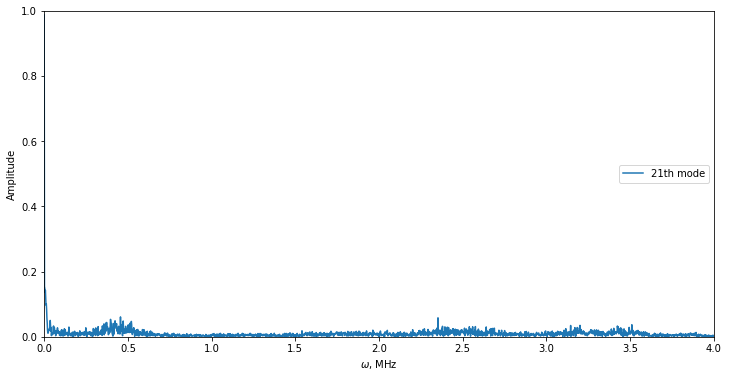

3.2217720996670045
[ 1.41083650e-02 -1.27749368e-02 -1.27749368e-02 -3.99814759e-03
 -3.99814759e-03  3.99814759e-03  3.99814759e-03  1.27749368e-02
  1.27749368e-02 -1.41083650e-02  1.70363806e-16 -2.56398713e-04
  2.56398713e-04  1.72123009e-02 -1.72123009e-02 -1.72123009e-02
  1.72123009e-02 -2.56398713e-04  2.56398713e-04  3.63360107e-17
  5.91986903e-01 -2.47192841e-02 -2.47192841e-02 -2.71274168e-01
 -2.71274168e-01 -2.71274168e-01 -2.71274168e-01 -2.47192841e-02
 -2.47192841e-02  5.91986903e-01]


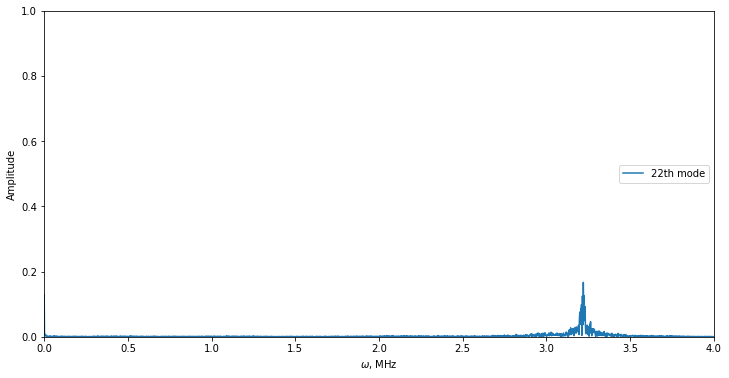

3.259547245958294
[-2.62919090e-01  3.30474499e-02  3.30474499e-02  9.84120949e-02
  9.84120949e-02  9.84120949e-02  9.84120949e-02  3.30474499e-02
  3.30474499e-02 -2.62919090e-01 -4.13625138e-16 -4.25578616e-01
  4.25578616e-01  1.52590181e-01 -1.52590181e-01  1.52590181e-01
 -1.52590181e-01  4.25578616e-01 -4.25578616e-01  4.13254125e-16
 -6.64655273e-03  1.42577137e-02  1.42577137e-02  5.78005519e-03
  5.78005519e-03 -5.78005519e-03 -5.78005519e-03 -1.42577137e-02
 -1.42577137e-02  6.64655273e-03]


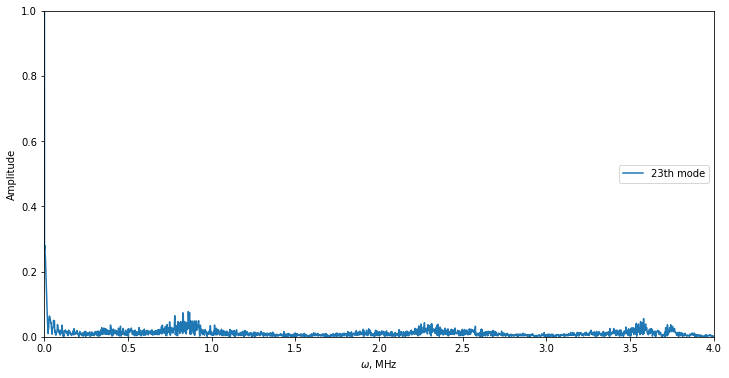

3.319460492978456
[ 1.55204945e-01 -3.78000423e-01 -3.78000423e-01  3.00397951e-01
  3.00397951e-01  3.00397951e-01  3.00397951e-01 -3.78000423e-01
 -3.78000423e-01  1.55204945e-01 -6.10106564e-16  1.54852988e-02
 -1.54852988e-02  6.63602484e-02 -6.63602484e-02  6.63602484e-02
 -6.63602484e-02 -1.54852988e-02  1.54852988e-02  7.16494078e-16
  1.16028027e-02 -1.09153317e-02 -1.09153317e-02 -1.59052794e-03
 -1.59052794e-03  1.59052794e-03  1.59052794e-03  1.09153317e-02
  1.09153317e-02 -1.16028027e-02]


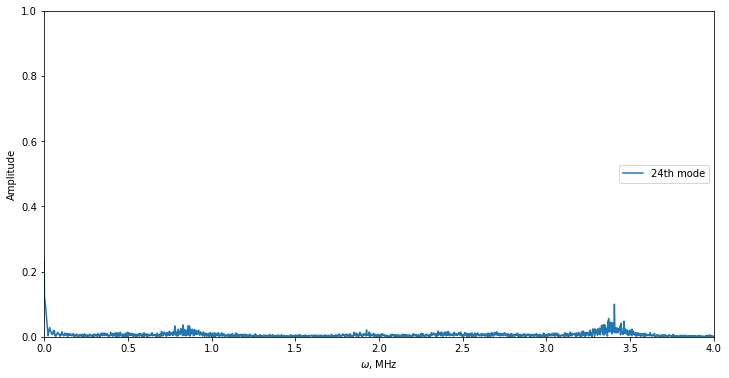

3.440237472840013
[-1.64511101e-01 -9.28386444e-03 -9.28386444e-03  2.56715187e-02
  2.56715187e-02 -2.56715187e-02 -2.56715187e-02  9.28386444e-03
  9.28386444e-03  1.64511101e-01 -5.98400439e-16 -3.40747696e-01
  3.40747696e-01  3.45708418e-01 -3.45708418e-01 -3.45708418e-01
  3.45708418e-01 -3.40747696e-01  3.40747696e-01 -5.55117160e-16
 -1.24435549e-02  1.93767301e-03  1.93767301e-03  4.28410443e-03
  4.28410443e-03  4.28410443e-03  4.28410443e-03  1.93767301e-03
  1.93767301e-03 -1.24435549e-02]


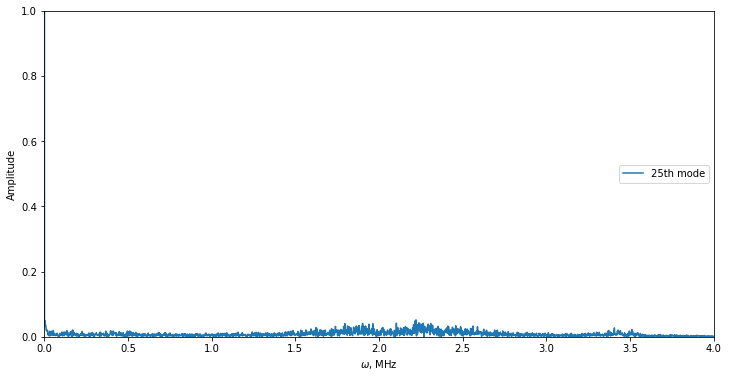

3.4595458420634557
[ 5.33401773e-03 -1.31523692e-03 -1.31523692e-03 -1.35177195e-03
 -1.35177195e-03 -1.35177195e-03 -1.35177195e-03 -1.31523692e-03
 -1.31523692e-03  5.33401773e-03  3.66771645e-17  5.07874270e-03
 -5.07874270e-03 -1.53043968e-03  1.53043968e-03 -1.53043968e-03
  1.53043968e-03 -5.07874270e-03  5.07874270e-03  4.19054910e-17
  5.32819571e-01  3.12559728e-01  3.12559728e-01  1.01548757e-01
  1.01548757e-01 -1.01548757e-01 -1.01548757e-01 -3.12559728e-01
 -3.12559728e-01 -5.32819571e-01]


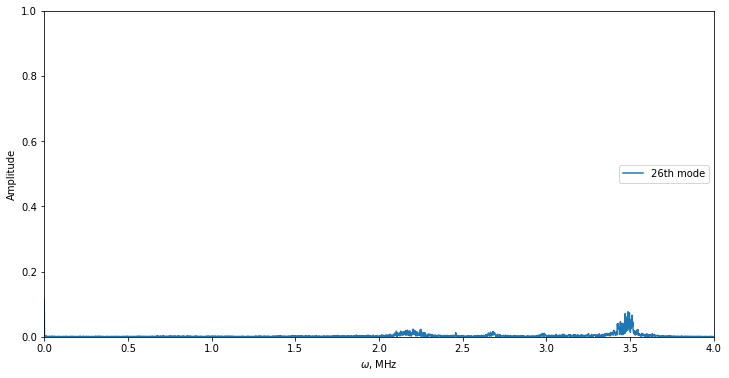

3.5283964831749484
[ 8.27874377e-16 -1.84350241e-01  1.84350241e-01 -4.61450528e-01
  4.61450528e-01 -4.61450528e-01  4.61450528e-01  1.84350241e-01
 -1.84350241e-01 -9.38648805e-16 -5.13117364e-02  3.95237335e-02
  3.95237335e-02 -1.38678653e-02 -1.38678653e-02 -1.38678653e-02
 -1.38678653e-02  3.95237335e-02  3.95237335e-02 -5.13117364e-02
  8.97719399e-16 -2.40406644e-03  2.40406644e-03 -1.31507144e-03
  1.31507144e-03  1.31507144e-03 -1.31507144e-03 -2.40406644e-03
  2.40406644e-03  4.83825219e-17]


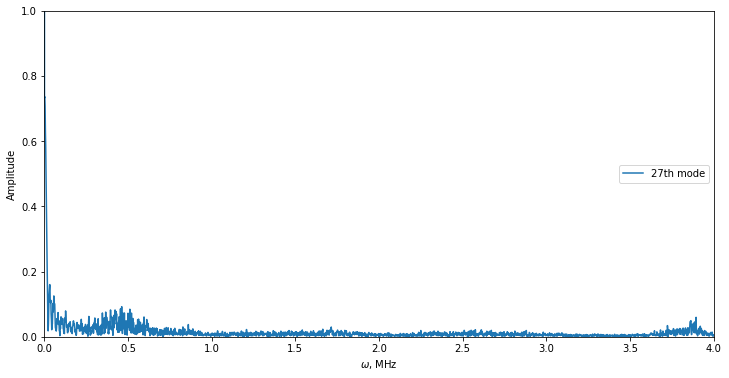

3.663317667707513
[ 2.85628103e-19 -9.98802194e-17  3.73046599e-17  1.20279426e-16
 -7.82001015e-17  2.23848409e-16 -1.46736756e-16 -2.10029522e-16
  1.61617646e-16 -1.47962616e-17 -4.13853994e-16  8.87790244e-17
  1.19197112e-16  9.71155781e-17  1.04178591e-16  7.13806397e-17
  3.35751983e-17  3.80323329e-17  9.30320640e-18  2.92063111e-16
  3.16227766e-01  3.16227766e-01  3.16227766e-01  3.16227766e-01
  3.16227766e-01  3.16227766e-01  3.16227766e-01  3.16227766e-01
  3.16227766e-01  3.16227766e-01]


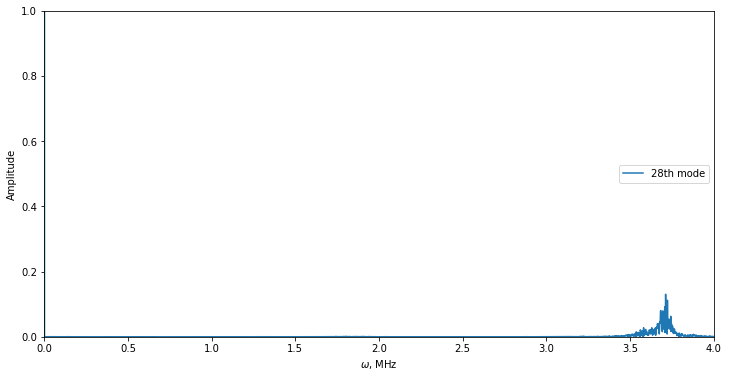

3.8662715653880966
[-3.00346859e-02  1.76514552e-01  1.76514552e-01 -4.65750462e-01
 -4.65750462e-01  4.65750462e-01  4.65750462e-01 -1.76514552e-01
 -1.76514552e-01  3.00346859e-02  1.25283739e-16  5.72369985e-03
 -5.72369985e-03  3.78051813e-02 -3.78051813e-02 -3.78051813e-02
  3.78051813e-02  5.72369985e-03 -5.72369985e-03  1.10429955e-16
 -1.19438453e-03  1.91024222e-03  1.91024222e-03 -1.31304995e-03
 -1.31304995e-03 -1.31304995e-03 -1.31304995e-03  1.91024222e-03
  1.91024222e-03 -1.19438453e-03]


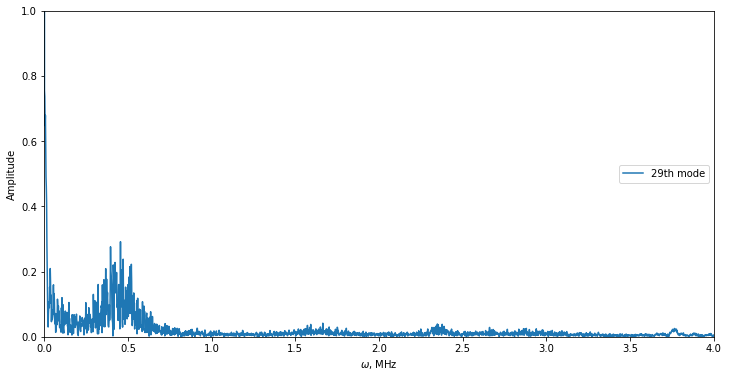

In [7]:
for n, ion_spectrum in enumerate(normal_spectrum):
    print(freqs[n]/1e6)
    print(modes[n])
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = str(n)+'th mode')
    plt.legend(loc = 'right')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(0, 4)
    plt.ylim(0, 1)
    plt.ylabel('Amplitude')
    plt.show()

In [11]:
fft_frequencies = []
for ion_spectrum in normal_spectrum:
    fft_frequencies.append(freqsfft[np.argmax(np.abs(ion_spectrum))])
    
print('Difference in normal frequencies:\n', freqs - fft_frequencies*1e6)

TypeError: can't multiply sequence by non-int of type 'float'